<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/meta_batchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
##import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
#for number-crunching
import numpy as np
import scipy.stats as stats
#for dataset management
import pandas as pd
#for timing computations
import time
#for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import and process the data

In [28]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
#drop few outliers
data=data[data['total sulfur dioxide']<200] #drop a few outliers
##z-score all variables except for quality
#find the columns we want to normalize
# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1


<ipython-input-28-fbebb6665483>:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
<ipython-input-28-fbebb6665483>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Re-organize the data:train/test in Dataloaders

In [29]:
#convert form pandas dataframe to tensor
dataT=torch.tensor(data[cols2zscore].values).float()
labels=torch.tensor(data['boolQuality'].values).float()
labels=labels[:,None]#transform to matrix


In [30]:
#split the data
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=0.1)
#then convert them into Pytorch datasets(note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)
#train and test dataloaders
test_loader=DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader=DataLoader(train_dataDataset,batch_size=32,shuffle=True,drop_last=True)


In [31]:
# create a class for the model

class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.bnorm1=nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,20)
    self.bnorm2=nn.BatchNorm1d(32)

    ### output layer
    self.output = nn.Linear(20,1)

  # forward pass
  def forward(self,x,doBN):
    x = F.relu( self.input(x) )#input
    if doBN:
      #hidden layer 1
      x = self.bnorm1(x)
      x = F.relu( self.fc1(x) )
      #hidden layer 2
      x = self.bnorm2(x)
      x = F.relu( self.fc2(x) )
    else:
      x = F.relu( self.fc1(x) ) # fully connected
      x = F.relu( self.fc2(x) )
    #output layer
    return self.output(x)

Train The model

In [32]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

Now for the experiment

In [33]:
#creat and train a model No batchNorm
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)
#creat and train a model No batchNorm
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)


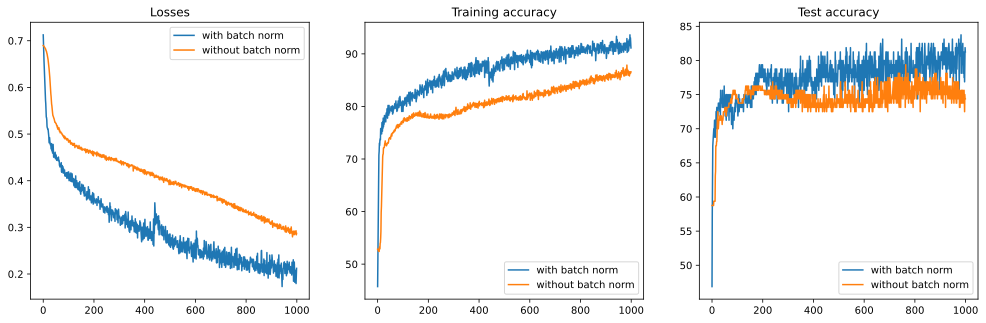

In [34]:
#plot some results
fig,ax=plt.subplots(1,3, figsize=(17,5))
ax[0].plot(lossesWith,label='with batch norm')
ax[0].plot(lossesNo,label='without batch norm')
ax[0].set_title('Losses')
ax[0].legend()
ax[1].plot(trainAccWith,label='with batch norm')
ax[1].plot(trainAccNo,label='without batch norm')
ax[1].set_title('Training accuracy')
ax[1].legend()
ax[2].plot(testAccWith,label='with batch norm')
ax[2].plot(testAccNo,label='without batch norm')
ax[2].set_title('Test accuracy')
ax[2].legend()
plt.show()